In [ ]:
!pip install kaggle

In [ ]:
import kagglehub
import os
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
import numpy as np
from concurrent.futures import ProcessPoolExecutor

In [ ]:
# Download latest version of kaggle dataset
path = kagglehub.dataset_download("devdope/900k-spotify")

print("Path to dataset files:", path)

100%|██████████| 1.00G/1.00G [00:09<00:00, 118MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/devdope/900k-spotify/versions/3


In [ ]:
# List files in the downloaded directory
print(os.listdir(path))

['final_milliondataset_BERT_500K_revised.json', 'spotify_dataset.csv', '900k Definitive Spotify Dataset.json']


In [ ]:
# Set CSV path
csv_path = path + "/spotify_dataset.csv"

## Part 1: Load and Inspect Data (Pandas)

In [ ]:
# Load dataset
df= pd.read_csv(csv_path)

# Display first 5 rows
df.head()

# Check shape
print("Shape of dataset:", df.shape)

# List column names
print("\nColumn names:")
print(df.columns.tolist())

# Show data types
print("\nData types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

Shape of dataset: (551443, 39)

Column names:
['Artist(s)', 'song', 'text', 'Length', 'emotion', 'Genre', 'Album', 'Release Date', 'Key', 'Tempo', 'Loudness (db)', 'Time signature', 'Explicit', 'Popularity', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Liveness', 'Acousticness', 'Instrumentalness', 'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation', 'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine', 'Similar Artist 1', 'Similar Song 1', 'Similarity Score 1', 'Similar Artist 2', 'Similar Song 2', 'Similarity Score 2', 'Similar Artist 3', 'Similar Song 3', 'Similarity Score 3']

Data types:
Artist(s)                          object
song                               object
text                               object
Length                             object
emotion                            object
Genre                              object
Album               

## Part  2: Applying Big Data Handling Strategies (Pandas)

In [ ]:
# ==============================
# ✅ Step 1: Load Less Data
# ==============================

# 📌 Dynamically get all column names
preview_df = pd.read_csv(csv_path, nrows=5)
all_columns = preview_df.columns.tolist()

# 📌 Define columns to exclude
columns_to_exclude = [
    'Similar Artist 2', 'Similar Song 2', 'Similarity Score 2',
    'Similar Artist 3', 'Similar Song 3', 'Similarity Score 3'
]

# 📌 Build final list of columns to keep
cols_to_use = [col for col in all_columns if col not in columns_to_exclude]

# 📌 Load only selected columns
start_load_optimized_lessdata = time.time()
df_optimized_lessdata = pd.read_csv(csv_path, usecols=cols_to_use)
end_load_optimized_lessdata = time.time()

# 📌 Measure memory usage
memory_usage_optimized_lessdata = df_optimized_lessdata.memory_usage(deep=True).sum() / (1024 * 1024)

print("✅ Step 1: Load Less Data")
print(f"📦 Memory usage: {memory_usage_optimized_lessdata:.2f} MB")
print(f"⏱️ Load time: {end_load_optimized_lessdata - start_load_optimized_lessdata:.4f} sec\n")

# ==============================
# ✅ Step 2: Use Chunking
# ==============================
chunk_size = 50000  # Adjust as needed
start_load_optimized_chunk = time.time()

chunk_list = []
for chunk in pd.read_csv(csv_path, chunksize=chunk_size):
    chunk_list.append(chunk)

df_optimized_chunk = pd.concat(chunk_list, ignore_index=True)
end_load_optimized_chunk = time.time()

memory_usage_optimized_chunk = df_optimized_chunk.memory_usage(deep=True).sum() / (1024 * 1024)

print("✅ Step 2: Chunking - All Columns")
print(f"📦 Memory usage: {memory_usage_optimized_chunk:.2f} MB")
print(f"⏱️ Load time: {end_load_optimized_chunk - start_load_optimized_chunk:.4f} sec\n")

# ==============================
# ✅ Step 3: Optimize Data Types
# ==============================
start_load_optimized_dtype = time.time()
df_optimized_dtype = pd.read_csv(csv_path)
end_load_optimized_dtype = time.time()

# 📌 Function to optimize data types
def optimize_dtypes(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == 'object':
            num_unique_values = df[col].nunique()
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        elif col_type == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

start_optimize_dtype = time.time()
df_optimized_dtype = optimize_dtypes(df_optimized_dtype)
end_optimize_dtype = time.time()

memory_usage_optimized_dtype = df_optimized_dtype.memory_usage(deep=True).sum() / (1024 * 1024)

print("✅ Step 3: Optimize Data Types - All Columns")
print(f"📦 Memory usage: {memory_usage_optimized_dtype:.2f} MB")
print(f"⏱️ Load time: {end_load_optimized_dtype - start_load_optimized_dtype:.4f} sec")
print(f"⚙️ Optimization time: {end_optimize_dtype - start_optimize_dtype:.4f} sec\n")

# ==============================
# ✅ Step 4: Sampling
# ==============================
start_time_pandas_optimized_sampling = time.time()
df_pandas = pd.read_csv(csv_path)
end_time_pandas_load_pandas_optimized_sampling = time.time()

start_time__pandas_optimized_sampling = time.time()
df_sampled = df_pandas.sample(frac=0.1, random_state=42)  # 10% random sampling
end_time_pandas_optimized_sampling = time.time()

memory_usage__pandas_optimized_sampling = df_sampled.memory_usage(deep=True).sum() / (1024 * 1024)

execution_time_pandas_load_optimized_sampling = end_time_pandas_load_pandas_optimized_sampling - start_time_pandas_optimized_sampling
execution_time_pandas_optimized_sampling = end_time_pandas_optimized_sampling - start_time__pandas_optimized_sampling

# Example processing: scaling 'Similarity Score 1' column
start_time_processing_pandas_optimized_sampling = time.time()
if 'Similarity Score 1' in df_sampled.columns:
    df_sampled['Similarity Score 1'] = (df_sampled['Similarity Score 1'] - df_sampled['Similarity Score 1'].mean()) / df_sampled['Similarity Score 1'].std()
end_time_processing_pandas_optimized_sampling = time.time()
execution_time_processing_pandas_optimized_sampling = end_time_processing_pandas_optimized_sampling - start_time_processing_pandas_optimized_sampling

print("✅ Step 4: Sampling")
print(f"📦 Memory usage after sampling: {memory_usage__pandas_optimized_sampling:.2f} MB")
print(f"⏱️ Load time (full dataset): {execution_time_pandas_load_optimized_sampling:.4f} sec")
print(f"⏱️ Sampling time: {execution_time_pandas_optimized_sampling:.4f} sec")
print(f"⚙️ Processing time (scaling Similarity Score 1): {execution_time_processing_pandas_optimized_sampling:.9f} sec")

✅ Step 1: Load Less Data
📦 Memory usage: 1790.17 MB
⏱️ Load time: 21.1007 sec

✅ Step 2: Chunking - All Columns
📦 Memory usage: 1950.00 MB
⏱️ Load time: 21.6816 sec

✅ Step 3: Optimize Data Types - All Columns
📦 Memory usage: 1766.80 MB
⏱️ Load time: 21.6686 sec
⚙️ Optimization time: 10.7711 sec

✅ Step 4: Sampling
📦 Memory usage after sampling: 195.08 MB
⏱️ Load time (full dataset): 25.0614 sec
⏱️ Sampling time: 0.5254 sec
⚙️ Processing time (scaling Similarity Score 1): 0.001819372 sec


## Part 3: Comparative Analysis between Pandas, Polars, and Dask for Full Dataset Loading

### 1. Pandas

In [ ]:
# Start measuring execution time
start_time_pandas = time.time()

# Load dataset with Pandas
df_pandas = pd.read_csv(csv_path)

# Measure memory usage
memory_usage_pandas = df_pandas.memory_usage(deep=True).sum()  # In bytes
memory_usage_MB_pandas = memory_usage_pandas / (1024 * 1024)  # Convert bytes to MB

# Stop timer and calculate execution time
execution_time_pandas = time.time() - start_time_pandas

# Display results
print(f"Memory usage of loading dataset using pandas: {memory_usage_MB_pandas:.2f} MB")
print(f"Execution time for loading dataset using pandas: {execution_time_pandas:.2f} seconds")

Memory usage of loading dataset using pandas: 1950.00 MB
Execution time for loading dataset using pandas: 18.54 seconds


### 2. Polars

In [ ]:
import polars as pl
import psutil

# Start measuring time and memory
process = psutil.Process(os.getpid())
start_time_polars = time.time()
start_mem_polars = process.memory_info().rss

# Load dataset with Polars
df_polars = pl.read_csv(csv_path)

# End measuring
end_time_polars = time.time()
end_mem_polars = process.memory_info().rss

# Calculate memory and time
memory_usage_MB_polars = (end_mem_polars - start_mem_polars) / (1024 * 1024)
execution_time_polars = end_time_polars - start_time_polars

# Display results
print(f"Memory usage of loading dataset using Polars: {memory_usage_MB_polars:.2f} MB")
print(f"Execution time for loading dataset using Polars: {execution_time_polars:.2f} seconds")

Memory usage of loading dataset using Polars: 1268.51 MB
Execution time for loading dataset using Polars: 2.88 seconds


### 3. Dask

In [ ]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# Start measuring time and memory
start_time_dask = time.time()
start_mem_dask = process.memory_info().rss

# Load dataset with Dask
df_dask = dd.read_csv(csv_path)

# Trigger computation to load metadata
with ProgressBar():
    df_dask.head(1)  # Light trigger to ensure it's read

# End measuring
end_time_dask = time.time()
end_mem_dask = process.memory_info().rss

# Calculate memory and time
memory_usage_MB_dask = (end_mem_dask - start_mem_dask) / (1024 * 1024)
execution_time_dask = end_time_dask - start_time_dask

# Display results
print(f"Memory usage of loading dataset using Dask: {memory_usage_MB_dask:.2f} MB")
print(f"Execution time for loading dataset using Dask: {execution_time_dask:.2f} seconds")

[########################################] | 100% Completed | 1.29 s
Memory usage of loading dataset using Dask: 112.71 MB
Execution time for loading dataset using Dask: 2.88 seconds


### 4. Comparison between 3 Libraries

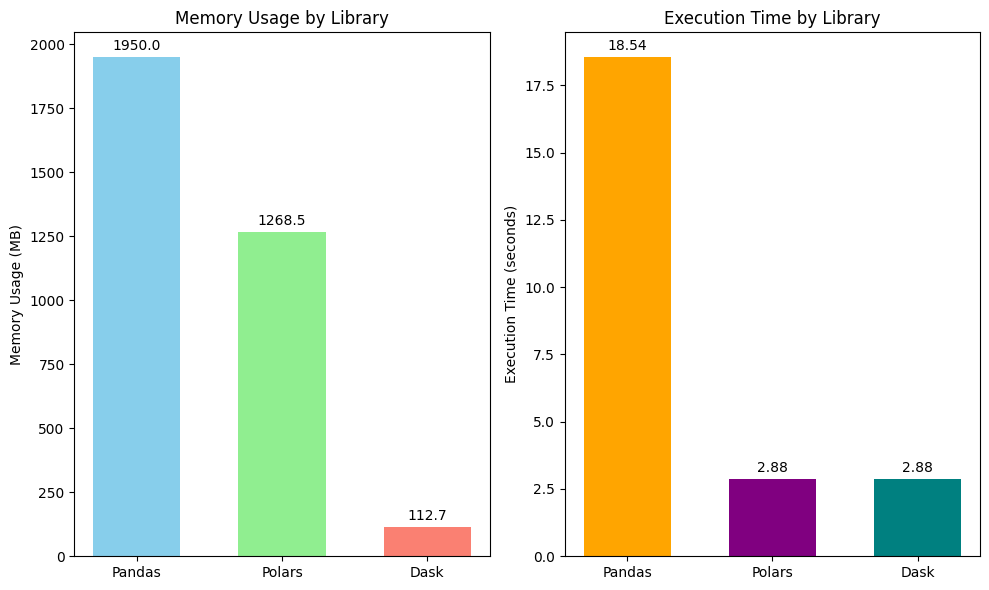

In [ ]:
import matplotlib.pyplot as plt

# Your data
tools = ['Pandas', 'Polars', 'Dask']
memory_usage = [memory_usage_MB_pandas, memory_usage_MB_polars, memory_usage_MB_dask]  # Memory in MB
execution_time = [execution_time_pandas, execution_time_polars, execution_time_dask]    # Time in seconds

# Custom colors
colors_memory = ['skyblue', 'lightgreen', 'salmon']
colors_time = ['orange', 'purple', 'teal']

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Memory Usage plot
bars1 = axes[0].bar(tools, memory_usage, color=colors_memory, width=0.6)
axes[0].set_ylabel('Memory Usage (MB)')
axes[0].set_title('Memory Usage by Library')
axes[0].bar_label(bars1, fmt='%.1f', padding=3)

# Execution Time plot
bars2 = axes[1].bar(tools, execution_time, color=colors_time, width=0.6)
axes[1].set_ylabel('Execution Time (seconds)')
axes[1].set_title('Execution Time by Library')
axes[1].bar_label(bars2, fmt='%.2f', padding=3)

# Adjust layout
plt.tight_layout()
plt.show()